In [1]:
from nilearn.maskers import NiftiMasker
from nilearn.input_data import NiftiMasker


In [2]:
from nilearn import datasets, plotting

development_dataset = datasets.fetch_development_fmri(n_subjects=None)

[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri


In [3]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print(
    f"MSDL has {n_regions} ROIs, "
    f"part of the following networks:\n{msdl_data.networks}."
)

[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/msdl_atlas
MSDL has 39 ROIs, part of the following networks:
['Aud', 'Aud', 'Striate', 'DMN', 'DMN', 'DMN', 'DMN', 'Occ post', 'Motor', 'R V Att', 'R V Att', 'R V Att', 'R V Att', 'Basal', 'L V Att', 'L V Att', 'L V Att', 'D Att', 'D Att', 'Vis Sec', 'Vis Sec', 'Vis Sec', 'Salience', 'Salience', 'Salience', 'Temporal', 'Temporal', 'Language', 'Language', 'Language', 'Language', 'Language', 'Cereb', 'Dors PCC', 'Cing-Ins', 'Cing-Ins', 'Cing-Ins', 'Ant IPS', 'Ant IPS'].


In [4]:

from nilearn.maskers import NiftiMapsMasker  # Correct import
import os
cache_dir = os.path.expanduser("~/nilearn_cache")

masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory=cache_dir,  # Set a user-writable directory
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds=True,
).fit()


In [5]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotype in zip(
    development_dataset.func,
    development_dataset.confounds,
    development_dataset.phenotypic["Child_Adult"],
):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotype == "child":
        children.append(time_series)
    groups.append(phenotype)

print(f"Data has {len(children)} children.")

Data has 122 children.


In [6]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

In [7]:
correlation_matrices = correlation_measure.fit_transform(children)

# All individual coefficients are stacked in a unique 2D matrix.
print(
    "Correlations of children are stacked "
    f"in an array of shape {correlation_matrices.shape}"
)

Correlations of children are stacked in an array of shape (122, 39, 39)


In [8]:
mean_correlation_matrix = correlation_measure.mean_
print(f"Mean correlation has shape {mean_correlation_matrix.shape}.")

Mean correlation has shape (39, 39).


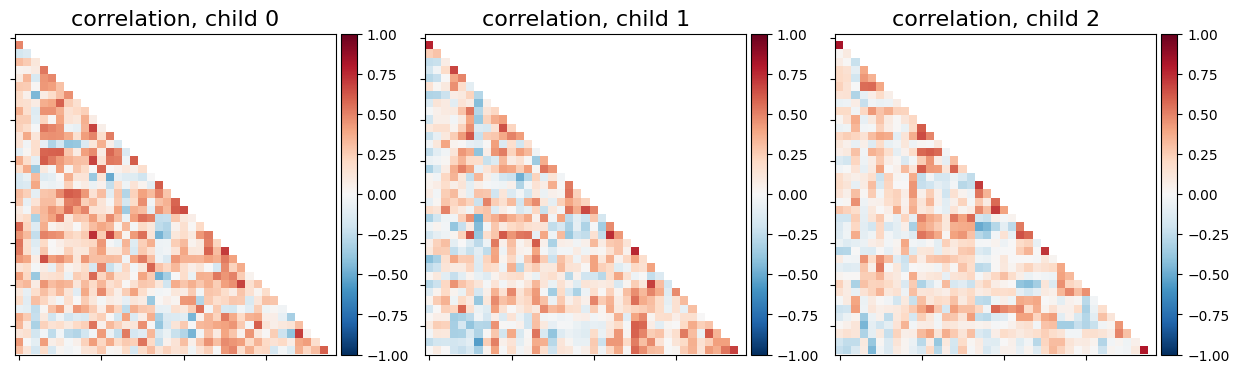

In [9]:
import numpy as np
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize=(15, 5))
vmax = np.absolute(correlation_matrices).max()
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(
        matrix,
        tri="lower",
        axes=ax,
        title=f"correlation, child {i}",
        vmax=vmax,
        vmin=-vmax,
    )

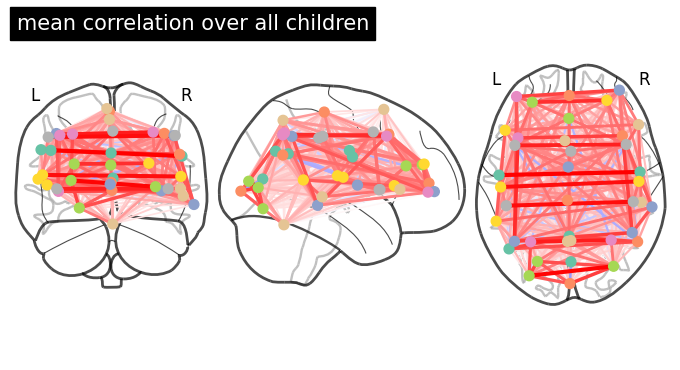

In [10]:
plotting.plot_connectome(
    mean_correlation_matrix,
    msdl_coords,
    title="mean correlation over all children",
)

In [11]:
tangent_measure = ConnectivityMeasure(
    kind="tangent",
    standardize="zscore_sample",
)

In [12]:
tangent_matrices = tangent_measure.fit_transform(children)

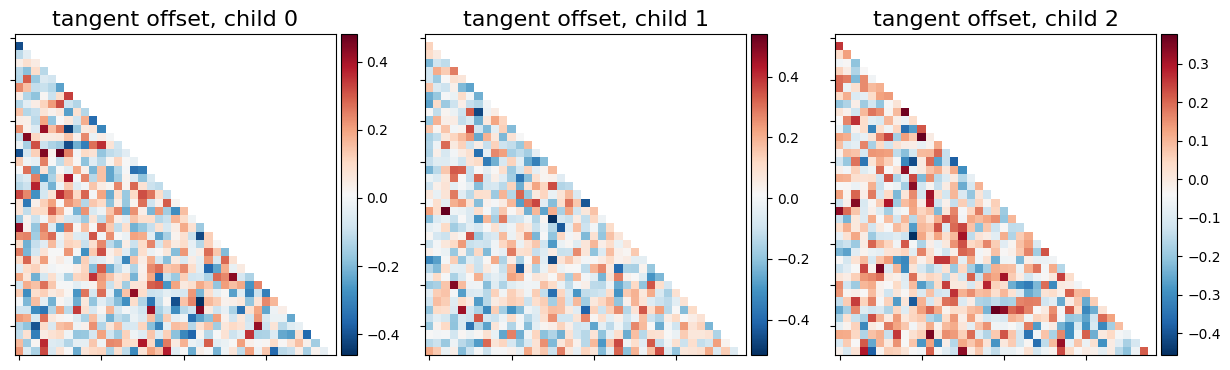

In [13]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(
        matrix,
        tri="lower",
        axes=ax,
        title=f"tangent offset, child {i}",
    )

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

kinds = ["correlation", "partial correlation", "tangent"]
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(
            kind=kind,
            vectorize=True,
            standardize="zscore_sample",
        )
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC(dual=True).fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test])
        )
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

Text(0.5, 0, 'Classification accuracy\n(red line = chance level)')

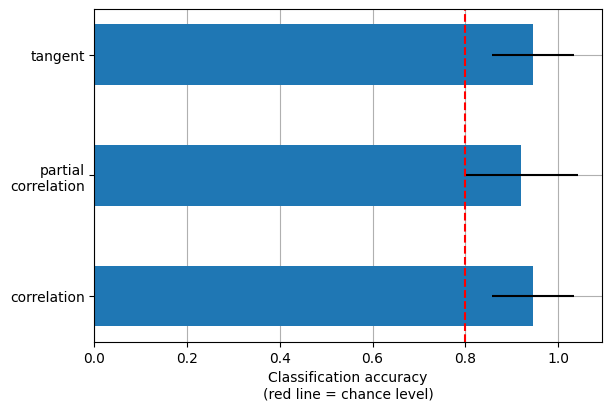

In [15]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4), constrained_layout=True)

positions = np.arange(len(kinds)) * 0.1 + 0.1
plt.barh(positions, mean_scores, align="center", height=0.05, xerr=scores_std)
yticks = [k.replace(" ", "\n") for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(0.8, color="red", linestyle="--")
plt.xlabel("Classification accuracy\n(red line = chance level)")

In [16]:
plotting.show()

In [17]:
print("Mean classification accuracies:")
for kind in kinds:
    print(f"{kind}: {np.mean(scores[kind]):.4f} ± {np.std(scores[kind]):.4f}")


Mean classification accuracies:
correlation: 0.9467 ± 0.0884
partial correlation: 0.9200 ± 0.1222
tangent: 0.9467 ± 0.0884
